<a href="https://colab.research.google.com/github/Ahmadsaidnouh/Term7-Artificial-Intelligence-Assignments/blob/lab4%2Fhossam/lab4/jupyter%20notebooks/Finallllllll_NLP_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install transformers
%pip install pandas 
%pip install torch
%pip install tqdm
%pip install nltk
%pip install configparser

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
import gc
import configparser
import ast
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
df_train = pd.read_csv(f"/content/drive/MyDrive/Lab4_Data/train.csv")
df_val = pd.read_csv(f"/content/drive/MyDrive/Lab4_Data/val.csv")
df_test = pd.read_csv(f"/content/drive/MyDrive/Lab4_Data/test.csv")
# df_train = df_train[0:5000]
# df_val = df_val[0:715]
# df_test = df_test[0:1430]


print(len(df_train), len(df_val), len(df_test))
df_train


5000 715 1430


,review,sentiment
0,yep lot shouting screaming cheering arguing ce...,negative
1,1st watched 832003 2 10dirbrad sykes mindless ...,negative
2,think movie probably lot powerful first debute...,positive
3,ive read lot review imdb well five one written...,negative
4,got usenet wasnt prepared heavy mean exception...,negative
...,...,...
4995,loved movie loved two family crossing path his...,positive
4996,think found misogynistic film time darklightbr...,negative
4997,dont know donald sutherland acting style vocal...,negative
4998,end episode holmes asks watson record case pos...,negative


In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
labels = {
    "negative" : 0 ,
    "positive" : 1,
}


class Dataset(torch.utils.data.TensorDataset):
    def __init__(self, df):

        self.labels = [labels[label] for label in df["sentiment"]]
        # self.labels = []
        # for label in df["sentiment"]:
        #     self.labels.append(label)
        self.texts = [
            tokenizer(
                text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            )
            for text in df["review"]
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [6]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_bert = nn.Dropout(0.5)
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(768, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, 256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 64)
        self.linear_out = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):
        _, x = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        x = self.dropout_bert(x)
        x = self.relu1(self.linear1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu2(self.linear2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu3(self.linear3(x))
        x = self.dropout(x)
        x = self.relu4(self.linear4(x))
        x = self.dropout(x)
        x = self.sigmoid(self.linear_out(x))
        return x


In [7]:
def save_checkpoint(model, epoch, optimizer, best_acc, model_path):
  state = {
      'epoch' : epoch + 1,
      'model' : model.state_dict(),
      'best accuracy' : best_acc,
      'optimizer' : optimizer.state_dict()
  }
  torch.save(state, model_path)

In [8]:
batch_size=16   
trainn, val, test = Dataset(df_train), Dataset(df_val), Dataset(df_test)

In [9]:
trainn

In [10]:
train_dataloader = torch.utils.data.DataLoader(trainn, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

In [11]:
epoch_list = list()
train_loss = list()
val_loss = list()
train_accuracy = list()
val_accuracy = list()

config_file = '/content/drive/MyDrive/Lab4_Data/config_1e6.ini'

try:
    # Load variables from config file
    config = configparser.ConfigParser()
    config.read(config_file)

    epoch_list = ast.literal_eval(config['VARIABLES']['epoch_list'])
    train_loss = ast.literal_eval(config['VARIABLES']['train_loss'])
    val_loss = ast.literal_eval(config['VARIABLES']['val_loss'])
    train_accuracy = ast.literal_eval(config['VARIABLES']['train_accuracy'])
    val_accuracy = ast.literal_eval(config['VARIABLES']['val_accuracy'])

    print(epoch_list)
    print(train_loss)
    print(val_loss)
    print(train_accuracy)
    print(val_accuracy)

except:
    print(f"Error while reading config file {config_file}")
    # Save variables to config file
    config = configparser.ConfigParser()
    config['VARIABLES'] = {'epoch_list': '[]',
                          'train_loss': '[]',
                          'val_loss': '[]',
                           'train_accuracy': '[]',
                           'val_accuracy': '[]'}

    with open(config_file, 'w') as configfile:
        config.write(configfile)

[1]
[0.043599981492757796]
[0.04356334357932366]
[0.4971]
[0.5045486354093772]


In [12]:
# train_loss = [0.04332565963949476, 0.04072417997632708, 0.03367434114473206, 0.043327143021992275]
# val_loss = [0.042853252792358396, 0.036830956387519834, 0.02853200067281723, 0.04247245973348618]
# train_accuracy = [0.5128, 0.6908, 0.8518571428571429, 0.5140285714285714]
# val_accuracy = [0.6198, 0.835, 0.8782, 0.65]
# epoch_list = [1,2,3,4]

# config.update({'VARIABLES':{'train_loss':train_loss,
#                             'val_loss':val_loss,
#                             'train_accuracy':train_accuracy,
#                             'val_accuracy':val_accuracy,
#                             'epoch_list':epoch_list}})
# with open(config_file, 'w') as configfile:
#     config.write(configfile)
def plot_all():
    plt.figure(figsize = [18, 5])
    plt.suptitle("Loss and Accuracy in training")
    plt.subplot(1,2,1)
    plt.plot(epoch_list,train_loss);
    plt.plot(epoch_list,val_loss);
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train","Validation"])
    plt.subplot(1,2,2)
    plt.plot(epoch_list,train_accuracy);
    plt.plot(epoch_list,val_accuracy);
    plt.xlabel("Epochs");
    plt.ylabel("Accuracy")
    plt.legend(["Train","Validation"]);
    plt.show()
    

In [13]:
def train(model,train_data, val_data, train_dataloader, val_dataloader, learning_rate, epochs, bach_size, best_model_path, last_model_path,start_from_epoch = 0):                    
    # Early stopping
    val_avg_acc_best = 0
    try:
      val_acc_best = max(val_accuracy)
    except:
      val_acc_best = -1000
      print("empty")
    early_stop_items_num = 5

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(start_from_epoch,epochs):
            gc.collect()
            # torch.cuda.empty_cache()

            model.train()
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                gc.collect()
                # torch.cuda.empty_cache()
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)

                batch_loss = criterion(output.squeeze(1), train_label.float())
                total_loss_train += batch_loss.item()

                y_pred_tag = torch.round(output.squeeze(1))
                acc = (y_pred_tag == train_label).sum()

                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            model.eval()
            with torch.no_grad():

                for val_input, val_label in val_dataloader:
                    gc.collect()
                    # torch.cuda.empty_cache()

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output.squeeze(1), val_label.float())
                    total_loss_val += batch_loss.item()
                    
                    y_pred_tag = torch.round(output.squeeze(1))
                    acc = (y_pred_tag == val_label).sum()
                    total_acc_val += acc
            
            train_loss.append(total_loss_train / len(train_data))
            train_accuracy.append(total_acc_train.item() / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            val_accuracy.append(total_acc_val.item() / len(val_data))
            epoch_list.append(epoch_num+1)
            val_acc_new = total_acc_val / len(val_data)
            
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            
            
            if val_acc_new > val_acc_best:
              val_acc_best = val_acc_new
              save_checkpoint(model, epoch_num, optimizer, val_acc_best, best_model_path)

            save_checkpoint(model, epoch_num, optimizer, val_acc_new, last_model_path)
            # Early stopping
            current_avg_acc = sum(val_accuracy[-early_stop_items_num:])/early_stop_items_num
            val_avg_acc_best = max(val_avg_acc_best, current_avg_acc)
            
            print(val_accuracy)
            print(early_stop_items_num)
            print(val_accuracy[-early_stop_items_num:])
            print("current_avg_acc = ", current_avg_acc)
            print("val_avg_acc_best = ", val_avg_acc_best)
            print("Difference = ", (val_avg_acc_best - current_avg_acc))

            if len(val_accuracy) >= early_stop_items_num and (val_avg_acc_best - current_avg_acc) >= 0.04:
                print("Early stopping at epoch:", epoch_num+1)
                break
            the_current_loss = total_loss_val / len(val_data)
            the_last_loss = the_current_loss
            config.update({'VARIABLES':{
                            'train_loss':train_loss,
                            'val_loss':val_loss,
                            'train_accuracy':train_accuracy,
                            'val_accuracy':val_accuracy,
                            'epoch_list':epoch_list}})
            with open(config_file, 'w') as configfile:
                config.write(configfile)
            # plot_all()
                  

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


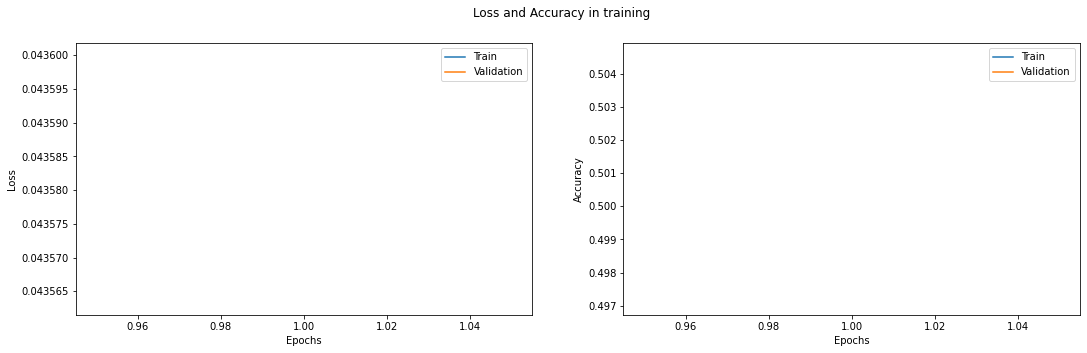

1


100%|██████████| 313/313 [08:00<00:00,  1.53s/it]


Epochs: 2 | Train Loss:  0.043                 | Train Accuracy:  0.513                 | Val Loss:  0.044                 | Val Accuracy:  0.502
[0.5045486354093772, 0.5020979020979021]
5
[0.5045486354093772, 0.5020979020979021]
current_avg_acc =  0.20132930750145586
val_avg_acc_best =  0.20132930750145586
Difference =  0.0


100%|██████████| 313/313 [08:00<00:00,  1.53s/it]


Epochs: 3 | Train Loss:  0.043                 | Train Accuracy:  0.507                 | Val Loss:  0.044                 | Val Accuracy:  0.474
[0.5045486354093772, 0.5020979020979021, 0.47412587412587415]
5
[0.5045486354093772, 0.5020979020979021, 0.47412587412587415]
current_avg_acc =  0.29615448232663066
val_avg_acc_best =  0.29615448232663066
Difference =  0.0


100%|██████████| 313/313 [07:57<00:00,  1.53s/it]


Epochs: 4 | Train Loss:  0.043                 | Train Accuracy:  0.520                 | Val Loss:  0.043                 | Val Accuracy:  0.541
[0.5045486354093772, 0.5020979020979021, 0.47412587412587415, 0.5412587412587413]
5
[0.5045486354093772, 0.5020979020979021, 0.47412587412587415, 0.5412587412587413]
current_avg_acc =  0.404406230578379
val_avg_acc_best =  0.404406230578379
Difference =  0.0


100%|██████████| 313/313 [07:58<00:00,  1.53s/it]


Epochs: 5 | Train Loss:  0.043                 | Train Accuracy:  0.510                 | Val Loss:  0.043                 | Val Accuracy:  0.566
[0.5045486354093772, 0.5020979020979021, 0.47412587412587415, 0.5412587412587413, 0.5664335664335665]
5
[0.5045486354093772, 0.5020979020979021, 0.47412587412587415, 0.5412587412587413, 0.5664335664335665]
current_avg_acc =  0.5176929438650923
val_avg_acc_best =  0.5176929438650923
Difference =  0.0


100%|██████████| 313/313 [08:00<00:00,  1.53s/it]


Epochs: 6 | Train Loss:  0.043                 | Train Accuracy:  0.529                 | Val Loss:  0.043                 | Val Accuracy:  0.622
[0.5045486354093772, 0.5020979020979021, 0.47412587412587415, 0.5412587412587413, 0.5664335664335665, 0.6223776223776224]
5
[0.5020979020979021, 0.47412587412587415, 0.5412587412587413, 0.5664335664335665, 0.6223776223776224]
current_avg_acc =  0.5412587412587413
val_avg_acc_best =  0.5412587412587413
Difference =  0.0


100%|██████████| 313/313 [07:58<00:00,  1.53s/it]


Epochs: 7 | Train Loss:  0.043                 | Train Accuracy:  0.543                 | Val Loss:  0.043                 | Val Accuracy:  0.670
[0.5045486354093772, 0.5020979020979021, 0.47412587412587415, 0.5412587412587413, 0.5664335664335665, 0.6223776223776224, 0.66993006993007]
5
[0.47412587412587415, 0.5412587412587413, 0.5664335664335665, 0.6223776223776224, 0.66993006993007]
current_avg_acc =  0.5748251748251748
val_avg_acc_best =  0.5748251748251748
Difference =  0.0


100%|██████████| 313/313 [07:57<00:00,  1.53s/it]


Epochs: 8 | Train Loss:  0.043                 | Train Accuracy:  0.581                 | Val Loss:  0.043                 | Val Accuracy:  0.691
[0.5045486354093772, 0.5020979020979021, 0.47412587412587415, 0.5412587412587413, 0.5664335664335665, 0.6223776223776224, 0.66993006993007, 0.6909090909090909]
5
[0.5412587412587413, 0.5664335664335665, 0.6223776223776224, 0.66993006993007, 0.6909090909090909]
current_avg_acc =  0.6181818181818183
val_avg_acc_best =  0.6181818181818183
Difference =  0.0


100%|██████████| 313/313 [07:58<00:00,  1.53s/it]


Epochs: 9 | Train Loss:  0.042                 | Train Accuracy:  0.613                 | Val Loss:  0.042                 | Val Accuracy:  0.762
[0.5045486354093772, 0.5020979020979021, 0.47412587412587415, 0.5412587412587413, 0.5664335664335665, 0.6223776223776224, 0.66993006993007, 0.6909090909090909, 0.7622377622377622]
5
[0.5664335664335665, 0.6223776223776224, 0.66993006993007, 0.6909090909090909, 0.7622377622377622]
current_avg_acc =  0.6623776223776223
val_avg_acc_best =  0.6623776223776223
Difference =  0.0


100%|██████████| 313/313 [07:56<00:00,  1.52s/it]


Epochs: 10 | Train Loss:  0.041                 | Train Accuracy:  0.667                 | Val Loss:  0.041                 | Val Accuracy:  0.779
[0.5045486354093772, 0.5020979020979021, 0.47412587412587415, 0.5412587412587413, 0.5664335664335665, 0.6223776223776224, 0.66993006993007, 0.6909090909090909, 0.7622377622377622, 0.779020979020979]
5
[0.6223776223776224, 0.66993006993007, 0.6909090909090909, 0.7622377622377622, 0.779020979020979]
current_avg_acc =  0.7048951048951049
val_avg_acc_best =  0.7048951048951049
Difference =  0.0


 46%|████▋     | 145/313 [03:43<04:19,  1.54s/it]


KeyboardInterrupt: ignored

In [14]:
EPOCHS = 10000
model = BertClassifier()
LR = 1e-6
best_model_path = f"/content/drive/MyDrive/Lab4_Data/model_best.pth.tar"
last_model_path = f"/content/drive/MyDrive/Lab4_Data/model_last.pth.tar"
gc.collect()
torch.cuda.empty_cache()
# plot_all()
epoch_num = 0
if len(epoch_list) != 0:
  epoch_num = epoch_list[-1]
print(epoch_num)
train(model, df_train, df_val, train_dataloader, val_dataloader, LR, EPOCHS,batch_size, best_model_path, last_model_path,start_from_epoch = epoch_num)
plot_all()

In [ ]:
print(train_loss)
print(train_accuracy)
print(val_loss)
print(val_accuracy)

print(epoch_list)

In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate(model, test_data, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    final_confusion_matrix = np.zeros([2,2])

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    model.eval()
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              # print(test_label)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              y_pred_tag = torch.round(output.argmax(dim=1))
              # print(y_pred_tag)
              for i in range(len(input_id)):
                tokens = tokenizer.convert_ids_to_tokens(input_id[i])
                text = tokenizer.convert_tokens_to_string(tokens)
                text = text.replace('[CLS] ','').replace(' [SEP]  ','').replace('[PAD]','')
                # print(text + " | Output : "+ labels[y_pred_tag.cpu().data.numpy()[i]] + " | Actual : " + labels[test_label.cpu().data.numpy()[i]])
              
              acc = (y_pred_tag == test_label).sum()
              total_acc_test += acc
              final_confusion_matrix += confusion_matrix(test_label.cpu().data.numpy(), y_pred_tag.cpu().data.numpy())
    
    TP = final_confusion_matrix[0][0]
    FP = final_confusion_matrix[0][1]
    FN = final_confusion_matrix[1][0]
    TN = final_confusion_matrix[1][1]
    Percision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print(f'Percision : {Percision}')
    print(f'Sensitivity (Recall) : {Recall}')
    print(f'Specifity : {TN/(TN+FP)}')
    print(f'F1 Score = {((2*Percision*Recall)/(Percision+Recall))}')
    print('Confusion Matrix :')
    print(final_confusion_matrix)
    


In [ ]:
loaded_checkpoint = torch.load(best_model_path)
model = BertClassifier()
model.load_state_dict(loaded_checkpoint["model"])

In [ ]:
evaluate(model, df_test, test_dataloader)